In [124]:
import os, glob, time, re, json, random
import cv2
import matplotlib.pyplot as plt

def time2frameStr(time, fps=30, frameFreq=4):
    h, m, s = time.split(":")
    frame = ( int(h)*3600 + int(m)*60 + float(s)*1 )*fps
    frame = str(int( frame//frameFreq*frameFreq + (frame%frameFreq>=frameFreq/2)*frameFreq ))
    return "0"*(5-len(frame)) + frame

def frameStr2time(frame, fps=30):
    frame = int(frame)/fps
    h, frame = str(int(frame//3600)), frame%3600
    m, s = str(int(frame//60)), round(frame%60,2)
    return f"{ '0'*(2-len(h)) + h }:{ '0'*(2-len(m))+m }:{s}"
        
def overlap(start1, end1, start2, end2):
    inter = max(0,min(end1,end2)-max(start1,start2))
    return inter / (end2-start2)

print("00:01:27.50", time2frame("00:01:27.50"), frame2time(frame))
print( overlap(int("07824"), int("07904"), int("07856"), int("07916")) ) # (60-12)/60=0.8

class LabeledCsv: # downstream # real data number = frames # active cycle must have trainCsvPathL and valCsvPath !!!
    def __init__(self, imgFolderL, outputFolder, classL, trainCsvPathL=[], txtPathL=[], valCsvPath=None):
        """
        + imgFolderL: folderL have all imgs
        + 2 types of sources
            + trainCsvPathL: inherit previous csvs
            + txtPathL: label videos txts
        + valCsvPath: copy it if specified else cut 20% from dataL as val.csv 
        """
        # hyperparameters
        self.fps, self.frameFreq, self.framesPerStack, self.divide, posThreshold, negThreshold = 30, 4, 16, 5, 0.75, 0.0
        self.posOverlap, self.negOverlap = round(self.framesPerStack*(1-posThreshold)), round(self.framesPerStack*negThreshold) # 4, 0
        # args
        self.imgPathL     = [] # idx2path
        for imgFolder in imgFolderL:
            self.imgPathL += sorted(glob.glob(f"{os.path.abspath(imgFolder)}/*.jpg"))
        self.imgPathD     = dict( zip( self.imgPathL,range(len(self.imgPathL)) ) ) # path2idx
        os.makedirs(outputFolder, exist_ok=True)
        self.outputFolder = outputFolder
        self.classL       = classL
        self.trainCsvPathL= trainCsvPathL
        self.jsonPathL    = self.labelCheckConversion(txtPathL)
        self.valCsvPath   = valCsvPath
    
    def labelCheckConversion(self, txtPathL): # eaiser to debug: time <-> frame # interval check 2.25~3.25 f
        for txtPath in txtPathL:
            D = {} # videoName -> timeSlotL[(cid,startFrame,endFrame)]
            r = open(txtPath, "r").read().replace(" ","")
            for videoBlock in r.split("\n\n"):
                for line in videoBlock.split("\n"):
                    if "[" in line:
                        currentVideo    = os.path.abspath( f"{self.imgPathL[0]}/../../{line[7:7+8]}/{line[1:-5]}" ) # .../_data/imgs/20220826/video_20220826000220
                        D[currentVideo] = []
                    else:
                        for cid,timeSlot in enumerate(line.split(",")):
                            if timeSlot != '-'*23:
                                start, end = timeSlot.split("-")
                                start, end = time2frameStr(start), time2frameStr(end)
                                assert 67.5<=int(end)-int(start)<=97.5, (currentVideo,timeSlot,end-start) # 2.25sec=67.5f < x < 3.25sec=97.5f
                                D[currentVideo].append( (cid,start,end) )
            json.dump( D, open(txtPath.replace(".txt",".json"), "w") )
        return [ txtPath.replace(".txt",".json") for txtPath in txtPathL ]
    
    def cut(self):
        # collect
        dataL = [ line for csvPath in self.trainCsvPathL for line in open(csvPath,"r").readlines() ] # trainCsvPathL
        for jsonPath in self.jsonPathL: # jsonPathL
            D = json.load(open(jsonPath,"r"))
            for path in D: # start new video block
                prevEnd = ""
                for cid,startFrameStr,endFrameStr in D[path]:
                    start = f"{path}_{startFrameStr}.jpg"
                    end   = f"{path}_{endFrameStr  }.jpg"
                    # positive
                    if True:
                        R = list(range(self.imgPathD[start]-self.posOverlap, self.imgPathD[end]-self.framesPerStack+self.posOverlap+1)) # startFrameIdx//4 range
                        random.shuffle(R)
                        for idx in R[:self.divide]:
                            imgPath = self.imgPathL[idx]
                            if overlap(int(startFrameStr), int(endFrameStr), int(imgPath[-9:-4]), int(imgPath[-9:-4])+60)>=0.73: # startFrame->0 may get previous video frames
                                dataL.append(f"{self.imgPathL[idx]} {cid}\n")
                            else:
                                print( "Invalid positive:", (startFrameStr,endFrameStr,imgPath) )
                    # negative
                    if prevEnd:
                        R = list(range(self.imgPathD[prevEnd]-self.negOverlap, self.imgPathD[start]-self.framesPerStack+self.negOverlap))
                        random.shuffle(R)
                        for idx in R[:self.divide]:
                            imgPath = self.imgPathL[idx]
                            if overlap(int(startFrameStr), int(endFrameStr), int(imgPath[-9:-4]), int(imgPath[-9:-4])+60)<0.03:
                                dataL.append(f"{self.imgPathL[idx]} {len(self.classL)}\n")
                            else:
                                print( "Invalid negative:", (startFrameStr,endFrameStr,imgPath) )
                    prevEnd = end
        # save
        random.shuffle(dataL)
        if self.valCsvPath:
            with open(f"{self.outputFolder}/train.csv","w") as f:
                for data in dataL:
                    f.write(data)
            os.system(f"cp {self.valCsvPath} {self.outputFolder}/val.csv")
            os.system(f"cp {self.valCsvPath} {self.outputFolder}/test.csv")
        else:
            with open(f"{self.outputFolder}/train.csv", "w") as f:
                for data in dataL[:int(len(dataL)*0.8)]:  
                    f.write(data)
            with open(f"{self.outputFolder}/val.csv", "w") as f:
                for data in dataL[int(len(dataL)*0.8):]:                  
                    f.write(data)
            os.system(f"cp {self.outputFolder}/val.csv {self.outputFolder}/test.csv")
        print( "data in [train.csv, val.csv, test.csv] =", [ len(open(f"{self.outputFolder}/{set1}.csv","r").readlines()) for set1 in ("train","val","test") ]  )

    def vis(self, num=1):
        lineL = open(f"{self.outputFolder}/train.csv", "r").readlines()
        R = list(range(len(lineL)))
        random.shuffle(R)
        for i in range(num):
            imgPath, cid = lineL[R[i]][:-1].split(" ")
            startIdx = self.imgPathD[imgPath]
            print(imgPath, cid, startIdx)
            plt.figure(figsize=(6*5,4*4))
            for j in range(4):
                for k in range(self.framesPerStack//4):
                    idx = j*self.framesPerStack//4+k
                    #print( self.imgPathL[startIdx+idx] )
                    plt.subplot(4,self.framesPerStack//4,1+idx)
                    plt.imshow( cv2.imread(self.imgPathL[startIdx+idx])[:,:,::-1] )
                    plt.axis('off')
            plt.show()
            
    def getClassCounts(self):
        for mode in ["train","val"]:
            countClassL = [0]*(len(self.classL)+1)
            for line in open(f"{self.outputFolder}/{mode}.csv", "r").readlines():
                imgPath, cid = line.split(" ")
                countClassL[int(cid)]+=1
            print(f"{mode} - countClassL={countClassL}")

00:01:27.50 02624 00:01:27.47
0.8


Invalid positive: ('00000', '00068', '/home/jovyan/data-vol-1/VideoMAE/_data/imgs/20220826/video_20220826001221_08920.jpg')
Invalid positive: ('00000', '00068', '/home/jovyan/data-vol-1/VideoMAE/_data/imgs/20220826/video_20220826001221_08916.jpg')
data in [train.csv, val.csv, test.csv] = [702, 176, 176]
/home/jovyan/data-vol-1/VideoMAE/_data/imgs/20220826/video_20220826001721_04864.jpg 2 7907


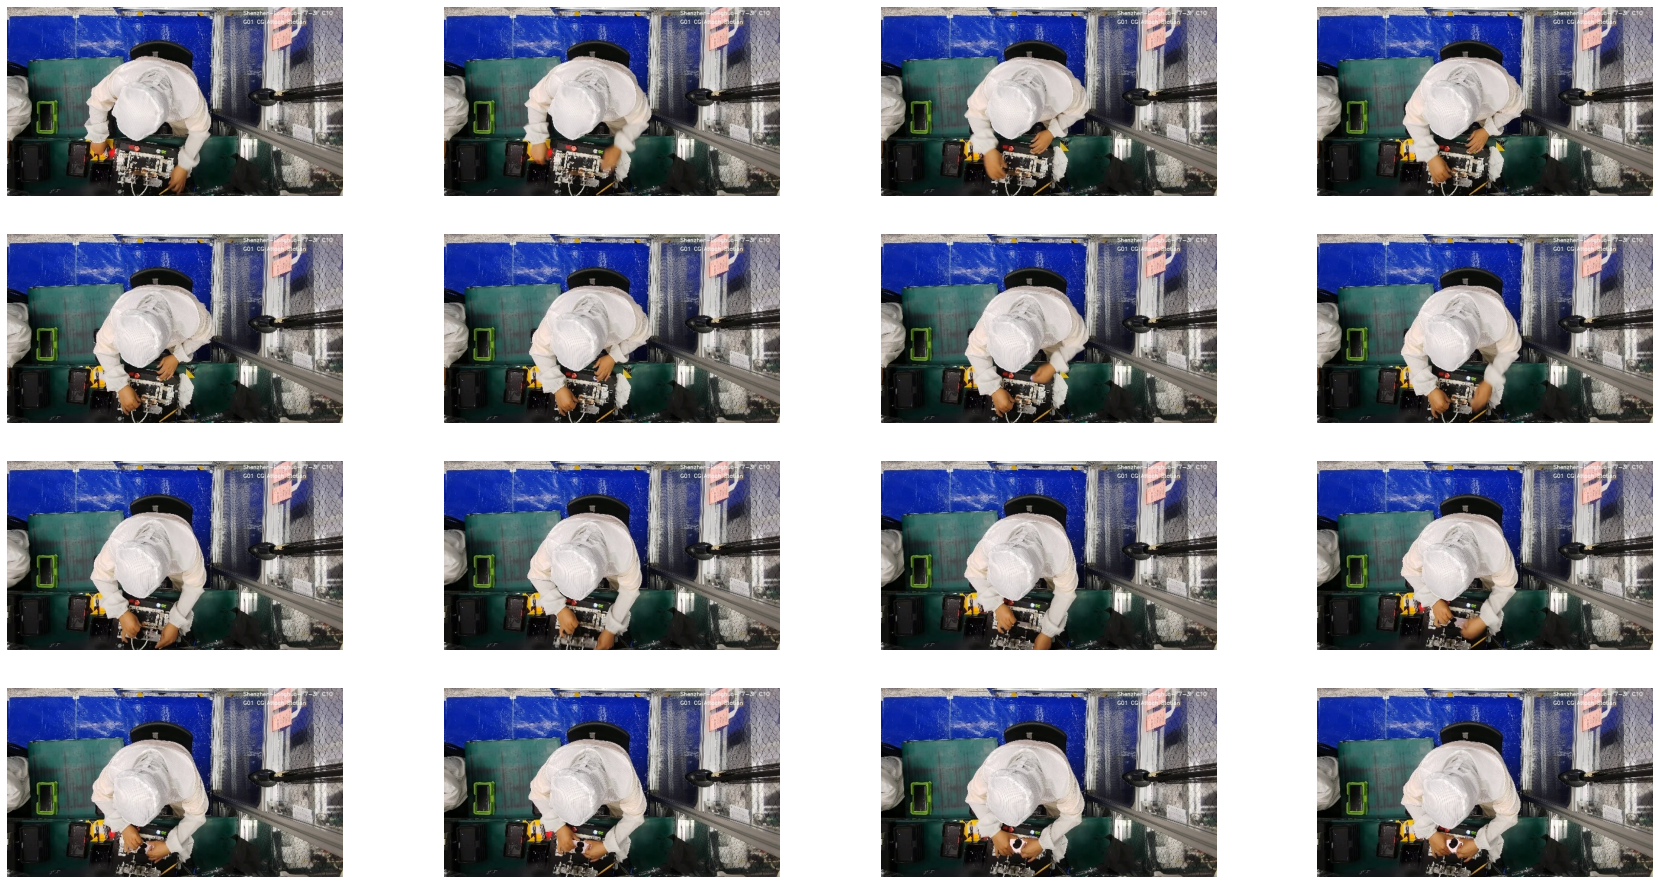

train - countClassL=[122, 119, 125, 336]
val - countClassL=[33, 29, 25, 89]


In [126]:
obj = LabeledCsv(imgFolderL=["../_data/imgs/20220826"], outputFolder="../_data/csvDownstream/20220826_v2", classL=['open','tear','close'], \
                 trainCsvPathL=[], txtPathL=["../_data/labels/labelv1.txt"], valCsvPath=None)
obj.cut()
obj.vis(1)
obj.getClassCounts()